# Introduction

## Time evolution

#### Describing how any quantum system evolves in time is determined by an initial state $\ket{\psi_0}$ and a Hamiltonian, $2^n \times 2^n$ Hermitean matrix. The state at a later time is calculated using the time-dependent Schrödinger equation:
#### $i \hbar \frac{\partial\ket{\psi(t)}}{\partial t} = H $$\ket{\psi(t)}$
#### This can be solved on a general form such that the state after a time t is given by
#### $\ket{\psi(t)} = e^{-iHt} \ket{\psi(0)}$
#### Here $\ket{\psi(0)}$ is the initial state you start from. This is a powerful equation that can simulate time evolution of quantum systems. However, the process quite quickly breakdown as the size of the Hamiltonian and by extension the states become to large to be simulated on computers. Quantum computers have some algorithms that can help with this scaling problem, but the Hamiltonian might be extremely complicated to implement as an unitary operation. In the following we will go through Trotter decomposition that approximates the Hamiltonians used in time evolution.

## Trotter decomposition

#### The Trotter decomposition is a method to decompose an expotential function of the sum of square matrices into a product of expotential function of square matrices. The first order Trotter formula is given by:
#### $e^{A+B} = \lim_{n\rightarrow} (e^\frac{A}{n}e^\frac{B}{n})^n$
#### This method can be done to different degrees of precision, the first order Trotter approximation of two square matrices A and B is given by:
#### $e^{\delta(A+B)} = e^{\delta A} e^{\delta B} + \mathcal{O}(\delta^2)$
#### The error term is needed since the matrices A and B do not necessarily commute. This approximation is very useful in Hamiltonian simulation since Hamiltonian usaully consists of a sum of non-commuting terms. The error term can be surpressed by increasing the number of times these expotential function are multiplied together, such that:
#### $e^{\delta(A+B)} = (e^{\delta \frac{A}{n}} e^{\delta \frac{B}{n}} + \mathcal{O}((\frac{\delta}{n})^2)^n$
#### The error term can then be made arbritrarily small by simply increasing the number n, although that of course increases the depth of the circuit.

#### In a specific case of the 1D Ising model, where $H = J \sum_{i=0}^m Z_i Z_{i+1}$ and m is the number of sites in the system. For this case the time evolution operator is given by:
#### $e^{-iHt} = e^{-i J \sum_{i=0}^m (Z_i Z_{i+1}) t} \approx (\Pi_i^m e^{-iJZ_iZ_{i+1} \frac{t}{n}})^n$
#### Here we see how this approximation works by turning the complicated Ising model time evolution operator into a product of individual time evolution operators that can be implemented in series. That is the large m qubit operator can be turned into a product of n 2 qubit operators.

## Higher Order Trotterization

#### The Trotter decomposition can be done with higher precision by including more trotter terms or by including more of the error term in the approximation. The first we are going to implement is the second order Trotter approximation:
#### $e^{-i\delta(A+B)} = e^{-i \frac{\delta}{2} A}  e^{-i \delta B} e^{-i \frac{\delta}{2} A} + \mathcal{O}(\delta^3)$
#### And can likewise be approximated by including introducing Trotter steps:
#### $e^{-i\delta(A+B)} \approx (e^{-i \frac{\delta}{2n} A}  e^{-i \frac{\delta}{n} B} e^{-i \frac{\delta}{2n} A})^n$
#### From this formula it might not be obvious what happens when there is more than two terms in the exponential, but it can be handled like so:
#### $e^{-i\delta(A+B+C)} \approx (e^{-i \frac{\delta}{2n} A}  e^{-i \frac{\delta}{2n} B} e^{-i \frac{\delta}{n} C} e^{-i \frac{\delta}{2n} B} e^{-i \frac{\delta}{2n} A})^n$
#### This can be generalised to any number of terms in the exponential

#### Higher order Trotter terms can be created recursively from this second order decomposition:
#### $\mathcal{P}_2(t) = e^{-iA t/2} e^{-iB t} e^{-iA t/2}$  
#### $\mathcal{P}_{2k}(t) = \mathcal{P}_{2k-2}(u_kt)^2 \mathcal{P}_{2k-2}((1-4u_k)t) \mathcal{P}_{2k-2}(u_kt)^2$  
#### with $u_k = 1 / (4 - 4^{1/(2k-1)})$
#### But this will not be covered in this project and we will not go into further details about higher order Trotterizations than second.

## Fidelity and Hilbert-Schmidt norm (2-norm)

#### Fidelity is a mathematical measurement of how "close" to quantum states are to each other. This measurement is done, for pure quantum states, by calculating the overlap of their coefficient and taking the absolute square:
#### $F(\psi, \phi) = \lvert\bra{\psi}\ket{\phi}\rvert^2$
#### This give us a measurable size to know how good the Trotterization approximation is. The values of the fidelity function are from 0 to 1, where 0 is two orthogonal states such as $\ket{0}$ and $\ket{1}$ with no overlap, i.e. not "close" to each other. Where 1 is only possible for two states that are equal. We can then measure the fidelity of the state from an exact time evolution and the state from a Trotterized time evolution to measure how good the approximation is.

#### Another method is to measure how "close" the two circuits are to each other. This can be done with the Hilbert-Schmidt norm (also known as the 2-norm). This is like the fidelity but for operators (matrices or circuits). This norm can be calculated with the trace:
#### $\lvert \lvert U,V \rvert \rvert_2 = \sqrt{\langle U, V \rangle_{HS}} = \sqrt{tr[U^\dagger V]}$
#### Where tr is the trace function, summing the diagonals of a matrix and $U^\dagger$ is the transpose and complex conjugate of U. The output of the 2-norm is between 0 and $\sqrt{d}$ where the d is the dimension of U. Here we normalise it to be between 0 and 1 to match the fidelity, where 0 is for orthogonal matrices and 1 is for equal matrcies. Here we only consider matrices that form quantum operators that is unitaries, which bounds to output to the stated above.

## Gate Noise

#### To simulate gate noise we first have to deconstruct our circuit into gates which noise can be added to. The matrix exponential of a Pauli matrix has a direct transformation to a set of arbritrary Z rotations, CNOTs, S and Hadamard gates. I will not go over all the details here, but more information can be found in these two papers: https://arxiv.org/pdf/quant-ph/9503016 and https://arxiv.org/pdf/1001.3855 
#### The basic building blocks we are going to be using here are:
#### $e^{i \frac{\theta}{2} Z} = R_z(\theta)$
#### $e^{i \frac{\theta}{2} (Z\otimes Z)} = CNOT (I \otimes R_z(\theta)) CNOT$
#### $e^{i \frac{\theta}{2} X} = H R_z(\theta) H$
#### Then I have created a function, which only works for the Ising Hamiltonian with two sites, that adds noise to these operations in the sense that they either work or does nothing.

# Initialising packages and functions

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from functools import reduce
from ipywidgets import interact

In [2]:
def kron_all(*gates):
    """
    Computes the Kronecker product of multiple gates.
    Example: kron_all([[A, B], C]) -> np.kron(np.kron(A, B), C)
    """
    #flatten the input
    flat = []
    for g in gates:
        if isinstance(g, list): #if g is [A, B] --> A, B
            flat.extend(g)
        else:
            flat.append(g)
    #compute Kronecker product
    return reduce(np.kron, flat)

In [3]:
#Some useful one qubit gates for initialisation of circuit
X = np.array([[0,1],[1,0]])
Y = np.array([[0,1j],[-1j,0]])
Z = np.array([[1,0],[0,-1]])
H = 1/np.sqrt(2) * np.array([[1,1],[1,-1]])
I = np.identity(2)
CNOT = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

In [4]:
class QuantumCircuit:
    def __init__(self, n):
        '''
        Initialises a quantum circuit in the 0 state with n qubits
        '''
        self.n = n
        self.state = np.zeros(2**n, dtype=np.complex128)
        self.state[0] = 1.0

    def __repr__(self):
        '''
        Makes itself printable
        '''
        return f"Statevector=\n{self.state}"

    def one_gate(self, gate, n, name = None):
        '''
        Apply any gate to qubit n in circuit
        '''        
        q = int(np.log2(len(self.state))) #number of qubits

        #tensor product between identity and gate to broadcast to circuit size
        operator = kron_all(
            [I] * n,
            gate,
            [I] * (q - n - 1) 
        ) 
        
        self.state = operator @ self.state

    def exact_time_evo(self, hamiltonian, t_max = 10, dt = 0.1):
        '''
        Calculates the exact time evolution of a Hamiltonian
        '''
        H_exact = eval(hamiltonian)
        initial_state = self.state
        
        t = np.linspace(0, t_max, int(t_max/dt))
        t = t[...,None, None]                        #reshape to be able to broadcast into H
        
        U_t = expm(-1j*H_exact*t)
        
        psi_t = U_t @ initial_state
        
        probabilities = np.abs(psi_t)**2
        return probabilities, t[:,0], psi_t, U_t

    def trotter_time_evo(self, hamiltonian, trotter_steps = 1000, t_max = 10, dt = 0.1, gate_decomposition = False, p = [0, 0, 0]):
        '''
        Calculates the Trotter approximation to time evolution to first order.
        If gate_decomposition = True, decompose gates into Paulis and count them
        '''
        initial_state = self.state                     

        t = np.linspace(0, t_max, int(t_max/dt))
        t = t[...,None, None]                        #reshape to be able to broadcast into H

        H_terms = [term for term in hamiltonian.split('+')]

        U_step = np.identity(eval(H_terms[0]).shape[0], dtype=np.complex128) #Hamiltonian shaped identity
        
        gate_count = {'CNOT': 0, 'R_z': 0, 'H': 0}
        
        if gate_decomposition:
            big_I = np.zeros((100, 2, 2), dtype=complex) #100 2x2 identities
            big_I[:,0,0] = 1
            big_I[:,1,1] = 1

            rng = np.random.default_rng() #rng generator
            a, b, c = p[0], p[1], p[2]
            H_prods = [prod.split('*') for prod in H_terms]

            U_t = np.identity(eval(H_terms[0]).shape[0], dtype=np.complex128)
            for _ in range(trotter_steps):
                U = np.identity(eval(H_terms[0]).shape[0], dtype=np.complex128)
                for i in H_prods:
                    Rz_matrices = np.zeros((100, 2, 2), dtype=complex)
                    Rz_matrices[:,0,0] = np.exp(-1j * eval(i[0]) / trotter_steps * t[:,0,0])
                    Rz_matrices[:,1,1] = np.exp(1j * eval(i[0]) / trotter_steps * t[:,0,0])
                    if ('Z, Z' in i[1]):
                        CNOT1 = rng.choice([CNOT,np.kron(I,I)], p=[1-a,a])
                        CNOT2 = rng.choice([CNOT,np.kron(I,I)], p=[1-a,a])
                        R_Z = np.kron(I, rng.choice([Rz_matrices, big_I], p=[1-b,b]))
                        U = U @ CNOT1 @ R_Z @ CNOT2
                        gate_count['CNOT'] += 2
                        gate_count['R_z'] += 1
                    if ('Z, I' in i[1]):
                        R_Z = np.kron(rng.choice([Rz_matrices, big_I], p=[1-b,b]), I)
                        U = U @ R_Z
                        gate_count['R_z'] += 1
                    if ('I, Z' in i[1]):
                        R_Z = np.kron(I, rng.choice([Rz_matrices, big_I], p=[1-b,b]))
                        U = U @ R_Z
                        gate_count['R_z'] += 1
                    if ('X, I' in i[1]):
                        H1 = np.kron(rng.choice([H,I], p=[1-c,c]), I)
                        H2 = np.kron(rng.choice([H,I], p=[1-c,c]), I)
                        R_Z = np.kron(rng.choice([Rz_matrices, big_I], p=[1-b,b]), I)
                        U = U @ H1 @ R_Z @ H2
                        gate_count['H'] += 2
                        gate_count['R_z'] += 1
                    if ('I, X' in i[1]):
                        H1 = np.kron(I, rng.choice([H,I], p=[1-c,c]))
                        H2 = np.kron(I, rng.choice([H,I], p=[1-c,c]))
                        R_Z = np.kron(I, rng.choice([Rz_matrices, big_I], p=[1-b,b]))
                        U = U @ H1 @ R_Z @ H2
                        gate_count['H'] += 2
                        gate_count['R_z'] += 1
                U_t = U @ U_t
            print('Gate counts for first order trotter:', gate_count)
        else:        
            for terms in H_terms:
                U_step = U_step @ expm(-1j * eval(terms) * t / trotter_steps)

            U_t = U_step
            for i in range(trotter_steps-1):
                U_t = U_t @ U_step
        
        psi_t = U_t @ initial_state

        probabilities = np.abs(psi_t)**2
        return probabilities, t[:,0], psi_t, U_t, gate_count

    def second_trotter(self, hamiltonian, trotter_steps = 1000, t_max = 10, dt = 0.1, gate_decomposition = False, p = [0, 0, 0]):
        '''
        Calculates the Trotter approximation to time evolution to second order
        '''
        initial_state = self.state

        t = np.linspace(0, t_max, int(t_max/dt))
        t = t[...,None, None]                        #reshape to be able to broadcast into H

        gate_count = {'CNOT': 0, 'R_z': 0, 'H': 0}
          
        H_terms = [term for term in hamiltonian.split('+')]
    
        if gate_decomposition:
            big_I = np.zeros((100, 2, 2), dtype=complex) #100 2x2 identities
            big_I[:,0,0] = 1
            big_I[:,1,1] = 1
            
            rng = np.random.default_rng() #rng generator
            a, b, c = p[0], p[1], p[2]
            H_prods = [prod.split('*') for prod in H_terms]
            
            U_t = np.identity(eval(H_terms[0]).shape[0], dtype=np.complex128)
            for _ in range(trotter_steps):
                Rz_matrices = np.zeros((100, 2, 2), dtype=complex)
                Rz_matrices[:,0,0] = np.exp(-1j * eval(H_prods[-1][0]) / trotter_steps * t[:,0,0])
                Rz_matrices[:,1,1] = np.exp(1j * eval(H_prods[-1][0]) / trotter_steps * t[:,0,0])
                if ('Z, Z' in H_prods[-1][1]):
                    CNOT1 = rng.choice([CNOT,np.kron(I,I)], p=[1-a,a])
                    CNOT2 = rng.choice([CNOT,np.kron(I,I)], p=[1-a,a])
                    R_Z = np.kron(I, rng.choice([Rz_matrices, big_I], p=[1-b,b]))
                    U = CNOT1 @ R_Z @ CNOT2
                    gate_count['CNOT'] += 2
                    gate_count['R_z'] += 1
                elif ('Z, I' in H_prods[-1][1]):
                    R_Z = np.kron(rng.choice([Rz_matrices, big_I], p=[1-b,b]), I)
                    U = R_Z
                    gate_count['R_z'] += 1
                elif ('I, Z' in H_prods[-1][1]):
                    R_Z = np.kron(I, rng.choice([Rz_matrices, big_I], p=[1-b,b]))
                    U = R_Z
                    gate_count['R_z'] += 1
                elif ('X, I' in H_prods[-1][1]):
                    H1 = np.kron(rng.choice([H,I], p=[1-c,c]), I)
                    H2 = np.kron(rng.choice([H,I], p=[1-c,c]), I)
                    R_Z = np.kron(rng.choice([Rz_matrices, big_I], p=[1-b,b]), I)
                    U = H1 @ R_Z @ H2
                    gate_count['H'] += 2
                    gate_count['R_z'] += 1
                elif ('I, X' in H_prods[-1][1]):
                    H1 = np.kron(I, rng.choice([H,I], p=[1-c,c]))
                    H2 = np.kron(I, rng.choice([H,I], p=[1-c,c]))
                    R_Z = np.kron(I, rng.choice([Rz_matrices, big_I], p=[1-b,b]))
                    U = H1 @ R_Z @ H2
                    gate_count['H'] += 2
                    gate_count['R_z'] += 1
                
                for i in reversed(H_prods[:-1]):
                    Rz_matrices = np.zeros((100, 2, 2), dtype=complex)
                    Rz_matrices[:,0,0] = np.exp(-1j * eval(i[0]) / (2 * trotter_steps) * t[:,0,0])
                    Rz_matrices[:,1,1] = np.exp(1j * eval(i[0]) / (2 * trotter_steps) * t[:,0,0])
                    if ('Z, Z' in i[1]): 
                        CNOT1 = rng.choice([CNOT,np.kron(I,I)], p=[1-a,a])
                        CNOT2 = rng.choice([CNOT,np.kron(I,I)], p=[1-a,a])
                        CNOT3 = rng.choice([CNOT,np.kron(I,I)], p=[1-a,a])
                        CNOT4 = rng.choice([CNOT,np.kron(I,I)], p=[1-a,a])
                        R_Z1 = np.kron(I, rng.choice([Rz_matrices, big_I], p=[1-b,b]))
                        R_Z2 = np.kron(I, rng.choice([Rz_matrices, big_I], p=[1-b,b]))
                        U = CNOT1 @ R_Z1 @ CNOT2 @ U @ CNOT3 @ R_Z2 @ CNOT4
                        gate_count['CNOT'] += 4
                        gate_count['R_z'] += 2
                    elif ('Z, I' in i[1]):
                        R_Z1 = np.kron(rng.choice([Rz_matrices, big_I], p=[1-b,b]), I)
                        R_Z2 = np.kron(rng.choice([Rz_matrices, big_I], p=[1-b,b]), I)
                        U = R_Z1 @ U @ R_Z2
                        gate_count['R_z'] += 2
                    elif ('I, Z' in i[1]):
                        R_Z1 = np.kron(I, rng.choice([Rz_matrices, big_I], p=[1-b,b]))
                        R_Z2 = np.kron(I, rng.choice([Rz_matrices, big_I], p=[1-b,b]))
                        U = R_Z1 @ U @ R_Z2
                        gate_count['R_z'] += 2
                    elif ('X, I' in i[1]):
                        H1 = np.kron(rng.choice([H,I], p=[1-c,c]), I)
                        H2 = np.kron(rng.choice([H,I], p=[1-c,c]), I)
                        H3 = np.kron(rng.choice([H,I], p=[1-c,c]), I)
                        H4 = np.kron(rng.choice([H,I], p=[1-c,c]), I)
                        R_Z1 = np.kron(rng.choice([Rz_matrices, big_I], p=[1-b,b]), I)
                        R_Z2 = np.kron(rng.choice([Rz_matrices, big_I], p=[1-b,b]), I)
                        U = H1 @ R_Z1 @ H2 @ U @ H3 @ R_Z2 @ H4
                        gate_count['H'] += 4
                        gate_count['R_z'] += 2
                    elif ('I, X' in i[1]):
                        H1 = np.kron(I, rng.choice([H,I], p=[1-c,c]))
                        H2 = np.kron(I, rng.choice([H,I], p=[1-c,c]))
                        H3 = np.kron(I, rng.choice([H,I], p=[1-c,c]))
                        H4 = np.kron(I, rng.choice([H,I], p=[1-c,c]))
                        R_Z1 = np.kron(I, rng.choice([Rz_matrices, big_I], p=[1-b,b]))
                        R_Z2 = np.kron(I, rng.choice([Rz_matrices, big_I], p=[1-b,b]))
                        U = H1 @ R_Z1 @ H2 @ U @ H3 @ R_Z2 @ H4
                        gate_count['H'] += 4
                        gate_count['R_z'] += 2
                U_t = U_t @ U
            print('Gate counts for second order trotter:', gate_count)
        else:
            U = expm(-1j * eval(H_terms[-1]) * t / (trotter_steps))
            for terms in reversed(H_terms[:-1]):
                U = expm(-1j * eval(terms) * t / (2 * trotter_steps)) @ U @ expm(-1j * eval(terms) * t / (2 * trotter_steps))
        
            U_t = U
            for i in range(trotter_steps-1):
                U_t = U_t @ U

        psi_t = U_t @ initial_state

        probabilities = np.abs(psi_t)**2
        return probabilities, t[:,0], psi_t, U_t, gate_count

In [5]:
def fidelity_func(psi_exact, psi_trotter):
    '''
    Calculates the fidelity between two states.
    '''
    overlap = np.sum(np.conjugate(psi_exact) * psi_trotter, axis=1, keepdims=True)
    fidelities = np.abs(overlap)**2
    return fidelities

def norm_func(U_exact, U_trotter):
    '''
    Calculate the 2-norm between two matrices.
    '''
    inner_prod = U_trotter.conjugate().transpose(0,2,1) @ U_exact   #U_trotter ^dag @ U_exact
    traces = np.trace(inner_prod, axis1 = 1, axis2 = 2)             #trace the matrices
    operator_norms = 1/np.sqrt(len(U_exact[1])) * np.sqrt(np.abs(traces))                     #1/sqrt{dim} * trace is operator norm
    return operator_norms

In [56]:
def plot_states(prob_exact, prob_trotter, time, num_qubits):
    '''
    Plots the qubit state's probability distribution for trotter and exact
    '''
    if type(prob_trotter) == np.ndarray:
        prob_trotter = [prob_trotter]
    fig, axes = plt.subplots(num_qubits, num_qubits, figsize=(10, 8))  
    axes = axes.flatten()  #So we can index axes[0]..axes[3]
    
    states = [format(i, f"0{num_qubits}b") for i in range(2**num_qubits)]  #Create a bit string for given state
    for i, state in enumerate(states):
        ax = axes[i]
        ax.plot(time, prob_exact[:, i], label="Exact", linestyle="--")
        for j in range(len(prob_trotter)):
            ax.plot(time, prob_trotter[j][:, i], label=f"Trotter {j}")
        ax.set_title(f"State |{state}⟩")
        ax.set_xlabel("Time")
        ax.set_ylabel("Probability")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def plot_fidelity(fidelity, norm, time):
    '''
    plot the fidelity and norm as a function of time
    '''
    if type(fidelity) == np.ndarray:
        fidelity = [fidelity]
    if type(norm) == np.ndarray:
        norm = [norm]
        
    fig, axes = plt.subplots(1, 2, figsize = (10,5), gridspec_kw=dict(wspace=0.4))

    for i in range(len(fidelity)):
        axes[0].plot(time, fidelity[i], label=f"fidelity {i}")
    for i in range(len(norm)):
        axes[1].plot(time, norm[i], label=f"2-norm {i}")
    
    ax0.set_ylabel("Fidelity", fontsize=14)
    ax1.set_ylabel("2-Norm", fontsize=14)

    for ax in axes:
        ax.set_xlabel("Time", fontsize=14)
        ax.spines[:].set_visible(False)
        ax.tick_params(bottom=False, left=False)
        ax.legend(bbox_to_anchor = (0,.4,.2,.3), mode = "expand", frameon=False, fontsize = 14)
        ax.grid()
    
    fig.suptitle("Fidelity and 2 norm as a function of time", fontsize = 18)
    
    plt.show()

# Simulations and plots

## Simulating the Ising Hamiltonian

#### Here we are simulating the Ising Hamiltonian with 2 sites and hopping terms. We have set the interaction between the spins to be J = 0.5, the individual spin to be g = 1 and the hopping terms have been set to h = 1. This model needs 2 qubits to run and each additional site needs a qubit. The implemented Hamiltonian is:
#### $H = J (Z \otimes Z) + g (Z \otimes I) + g (I \otimes Z) + h (X \otimes I) + h (I \otimes X)$

In [46]:
## Physical quantaties
J = 0.5
g = 1
h = 1

#Ising Hamiltonian for 2 sites
hamiltonian = 'J * np.kron(Z, Z) + g * np.kron(Z, I) + g * np.kron(I, Z) + h * np.kron(X, I) + h * np.kron(I, X)'

#number of qubits
n = 2

#Setting up an initial state
qc = QuantumCircuit(n)

#### The Hamiltonian is given as a string which is necessary for the functions to work. This is done to split the terms such that the Trotter approximation can handle each term individually.
#### The number of qubits is exactly how many sites are included in the Hamiltonian and the initial state is set to be the $\ket{0^n}$ state. This can be altered by using qc.one_gate(name of gate, acting on qubit), example: qc.one_gate(X,1) will create the $\ket{10}$ for a two qubit system.

In [47]:
#max time
t_max = 10
dt = 0.1

#exact time evolution
probabilities_exact, time, psi_exact, U_exact = qc.exact_time_evo(hamiltonian, t_max = t_max, dt = dt)

#### Above is the exact time evolution for a system running for 10 units of time with a stepsize of 0.1, this is used to compare with later results

## First order Trotter

#### Now we are going to simulate the first order Trotterization with the exact result. Then we plot the states of exact results as dashed line. The amount of Trotter steps is set to 50, but increasing this will yield a better approximation.

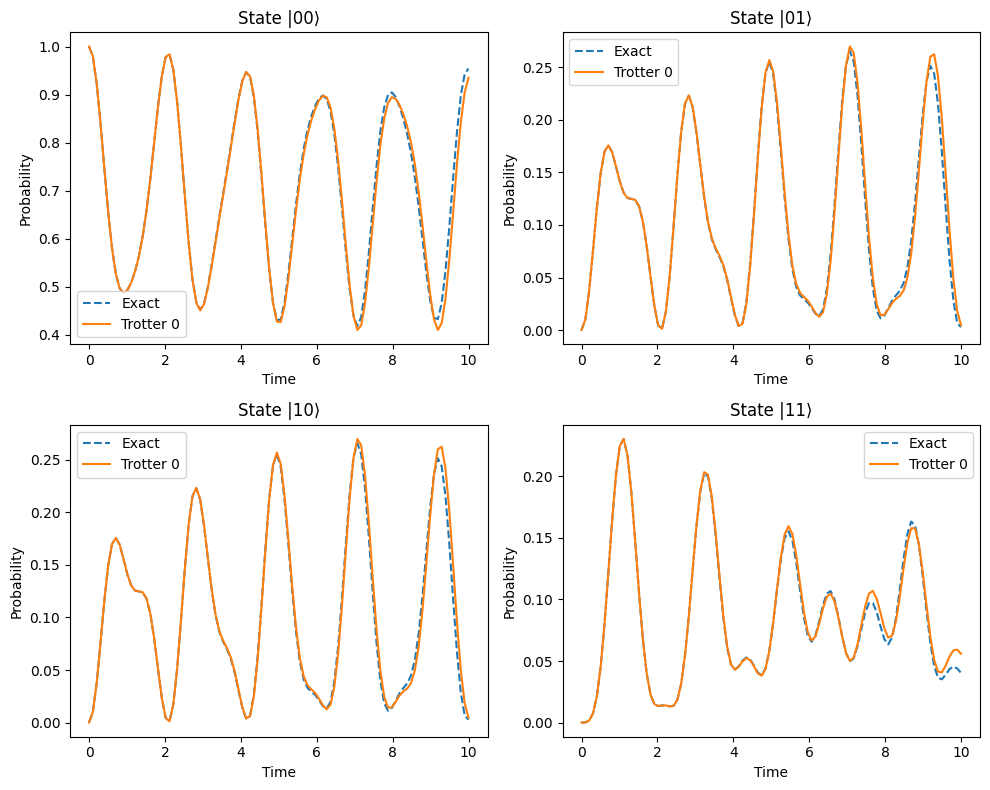

In [48]:
#trotter time evolution
trotter_steps = 50                  # <-- change this
probalitities_trotter, time, psi_trotter, U_trotter, gate_count = qc.trotter_time_evo(
    hamiltonian, 
    trotter_steps = trotter_steps, 
    t_max = t_max, 
    dt = dt
)

#plotting
plot_states(
    prob_exact = probabilities_exact,
    prob_trotter = probalitities_trotter,
    time = time,
    num_qubits = n
)

### Quantifying the results
#### Above we see the first order trotter approximation and it looks pretty good, but it can be hard to tell how well the approximation worked. Below we calculate the fidelity between the exact state and trotter state, and the 2-norm between the two circuits.

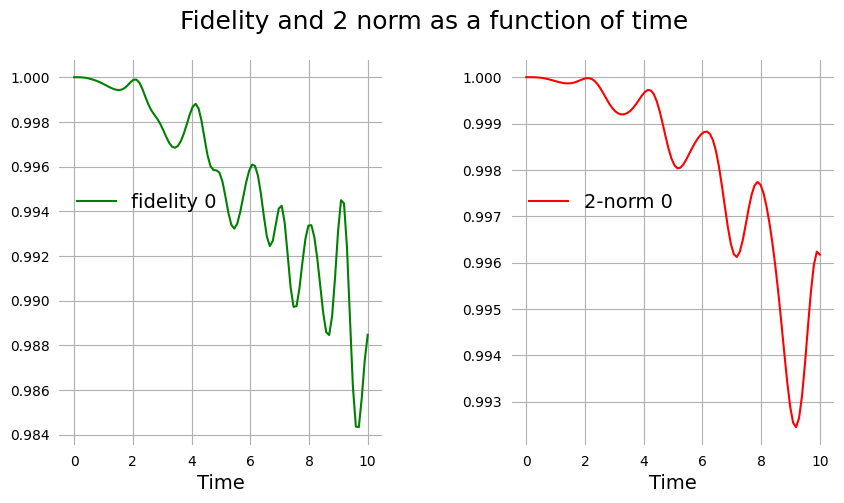

In [49]:
fidelities = fidelity_func(psi_exact = psi_exact, psi_trotter = psi_trotter)
norms = norm_func(U_exact = U_exact, U_trotter = U_trotter)

plot_fidelity(
    fidelity=fidelities,
    norm=norms,
    time=time
)

#### This is a much easier way to quantify the quality of the approximation. Try to increase and decrease the number of trotter steps and notice the change in 2-norm and fidelity

## Second Order Trotter

#### Here we are implementing the second order trotter approximation for the same Hamiltonian as before. Again the amount of trotter steps are set 50.

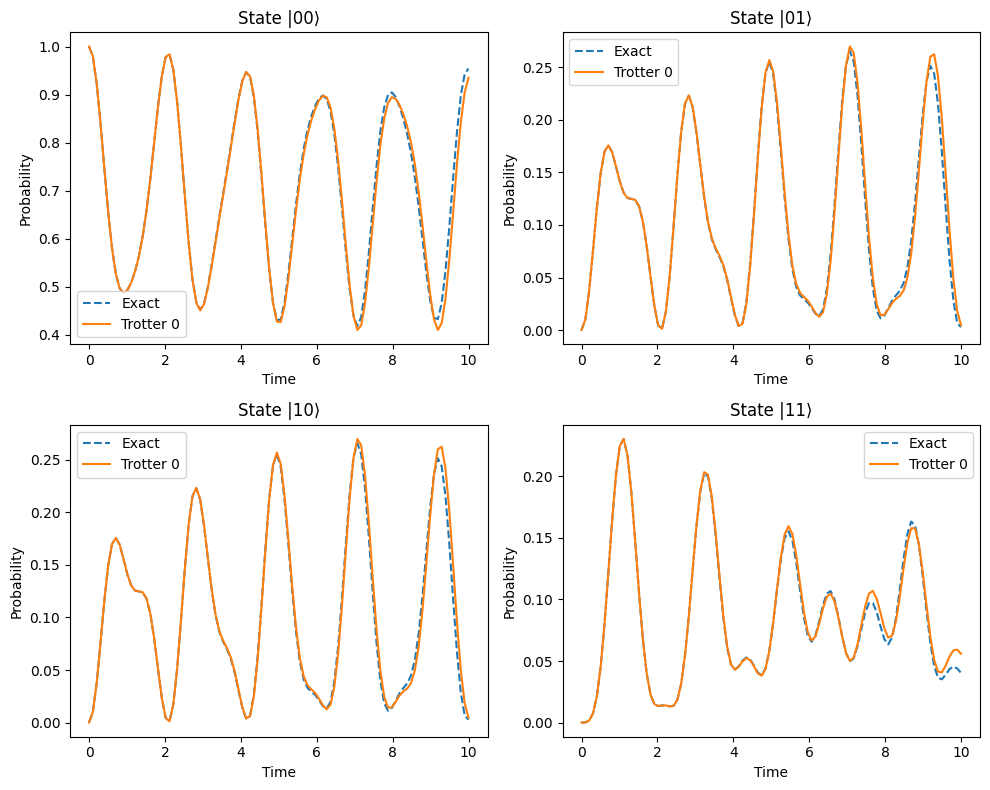

In [50]:
#max time
t_max = 10
dt = 0.1

#trotter time evolution
trotter_steps = 50
probalitities_trotter2, time, psi_trotter2, U_trotter2, gate_count2 = qc.second_trotter(
    hamiltonian, 
    trotter_steps = trotter_steps, 
    t_max = t_max, 
    dt = dt
)

#plotting
plot_states(
    prob_exact = probabilities_exact,
    prob_trotter = probalitities_trotter2,
    time = time,
    num_qubits = n
)

### Quantifying the results
#### Again this is hard to see how well the approximation is, and also comparing to the first order approximation. Let us calculate the fidelity and 2-norm.

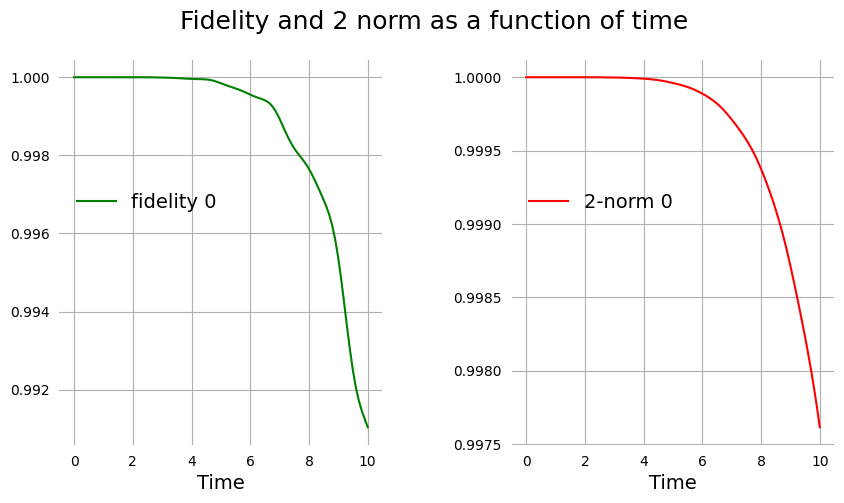

In [51]:
fidelities2 = fidelity_func(psi_exact = psi_exact, psi_trotter = psi_trotter2)
norms2 = norm_func(U_trotter = U_trotter2, U_exact = U_exact)

plot_fidelity(
    fidelity=fidelities2,
    norm=norms2,
    time=time
)

#### Here we can see that the second order Trotterization performs better than the first order Trotterization but it is still hard to compare properly.

## Comparison of first and second order Trotterization

#### Instead of comparing the two orders of Trotterization in time, we will now compare the two orders by how many trotter steps they need use to hit a fidelity and 2-norm target. Here we have set the targets to 0.99, 0.999, 0.9999, 0.99999, but feel free to add more. This has been hard coded to work but does not work fast as it is calculating the Trotterization function a couple thousand times. The cell below takes about 30-40 seconds to run.

In [52]:
#max time
t_max = 10
dt = 0.1

fidelity_targets = [0.99, 0.999, 0.9999, 0.99999]
norm_targets = fidelity_targets
fidelity_1 = 0
fidelity_2 = 0
norm_1 = 0
norm_2 = 0
trotter_steps_required_fidelity_1 = []
trotter_steps_required_norm_1 = []
trotter_steps_required_fidelity_2 = []
trotter_steps_required_norm_2 = []

m = 0
for target in fidelity_targets:
    while fidelity_1 < target:
        m += 1
        
        _, _, psi_trotter, U_trotter, _ = qc.trotter_time_evo(hamiltonian, trotter_steps = m, t_max = t_max, dt = dt)
        
        fidelity_1 = fidelity_func(psi_exact = psi_exact, psi_trotter = psi_trotter)[-1]
        
    trotter_steps_required_fidelity_1.append(m)

m = 0
for target in norm_targets:
    while norm_1 < target:
        m += 1
        
        _, _, psi_trotter, U_trotter, _ = qc.trotter_time_evo(hamiltonian, trotter_steps = m, t_max = t_max, dt = dt)
        
        norm_1 = operator_norms = norm_func(U_trotter = U_trotter, U_exact = U_exact)[-1]
        
    trotter_steps_required_norm_1.append(m)

m = 0
for target in fidelity_targets:
    while fidelity_2 < target:
        m += 1
        
        _, _, psi_trotter_2, U_trotter_2, _ = qc.second_trotter(hamiltonian, trotter_steps = m, t_max = t_max, dt = dt)
        
        fidelity_2 = fidelity_func(psi_exact = psi_exact, psi_trotter = psi_trotter_2)[-1]
        
    trotter_steps_required_fidelity_2.append(m)

m = 0
for target in norm_targets:
    while norm_2 < target:
        m += 1
        
        _, _, psi_trotter_2, U_trotter_2, _ = qc.second_trotter(hamiltonian, trotter_steps = m, t_max = t_max, dt = dt)
        
        norm_2 = operator_norms = norm_func(U_trotter = U_trotter_2, U_exact = U_exact)[-1]
        
    trotter_steps_required_norm_2.append(m)

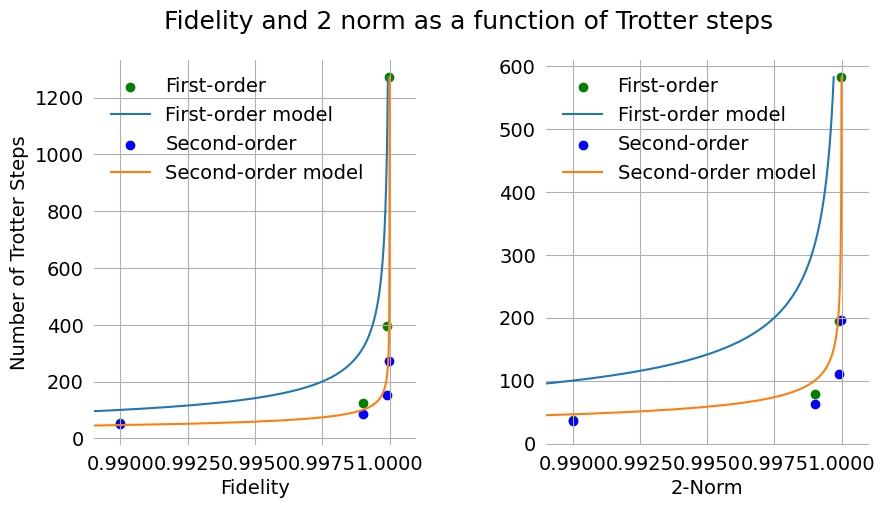

In [53]:
x = np.linspace(min(trotter_steps_required_fidelity_2)-10,max(trotter_steps_required_fidelity_1), max(trotter_steps_required_fidelity_2)-10-min(trotter_steps_required_fidelity_1))
y = np.linspace(min(trotter_steps_required_norm_2)-10,max(trotter_steps_required_norm_1), max(trotter_steps_required_norm_2)-min(trotter_steps_required_norm_1))

#plot the results from above
fig, (ax0,ax1) = plt.subplots(1, 2, figsize = (10,5), gridspec_kw=dict(wspace=0.4))

ax0.scatter(fidelity_targets, trotter_steps_required_fidelity_1, marker = 'o', color = 'green', label="First-order")
ax0.plot(1-(10/x)**2, x, label = "First-order model")
ax0.scatter(fidelity_targets, trotter_steps_required_fidelity_2, marker = 'o', color = 'blue', label="Second-order")
ax0.plot(1-(10/x)**3, x, label = "Second-order model")
ax1.scatter(norm_targets, trotter_steps_required_norm_1, marker = 'o', color = 'green', label="First-order")
ax1.plot(1-(10/y)**2, y, label = "First-order model")
ax1.scatter(norm_targets, trotter_steps_required_norm_2, marker = 'o', color = 'blue', label="Second-order")
ax1.plot(1-(10/y)**3, y, label = "Second-order model")

ax0.set_ylabel("Number of Trotter Steps", fontsize=14)
ax0.set_xlabel("Fidelity", fontsize=14)
ax1.set_xlabel("2-Norm", fontsize=14)

ax0.spines[:].set_visible(False)
ax1.spines[:].set_visible(False)

ax0.tick_params(bottom=False, left=False)
ax1.tick_params(bottom=False, left=False)

ax0.set_xlim(0.989,1.001)
ax1.set_xlim(0.989,1.001)

ax0.tick_params(axis='both', labelsize=14)
ax1.tick_params(axis='both', labelsize=14)

ax0.legend(bbox_to_anchor = (0,.7,.2,.3), mode = "expand", frameon=False, fontsize = 14)
ax1.legend(bbox_to_anchor = (0,.7,.2,.3), mode = "expand", frameon=False, fontsize = 14)

ax0.grid()
ax1.grid()

fig.suptitle("Fidelity and 2 norm as a function of Trotter steps", fontsize = 18)

plt.show()

#### Here it is easy to that the second order approximation is working a lot better than first order. For lower fidelity their performance is quite similar, but for the accurate cases they are very distinct. The model is created by calculting 1 - error, for all trotter steps used.

## Noisy Gates

In [58]:
#max time
t_max = 10
dt = 0.1

@interact(CNOT_error=(0.0001, 0.01, 0.0001), R_z_error=(0.00001, 0.001, 0.00001), H_error=(0.000001, 0.001, 0.000001), trotter_steps = (1, 1000, 1))
def plot_noisy(CNOT_error = 0.001, R_z_error = 0.0001, H_error = 0.00001, trotter_steps = 50):
    #noise
    p = [CNOT_error, R_z_error, H_error]
    
    #first order trotter time evolution
    probalitities_trotter, time, psi_trotter, U_trotter, gate_count = qc.trotter_time_evo(
        hamiltonian, 
        trotter_steps = trotter_steps, 
        t_max = t_max, 
        dt = dt,
        gate_decomposition = True, 
        p = p
    )
    
    #second order trotter time evolution
    probalitities_trotter2, time, psi_trotter2, U_trotter2, gate_count2 = qc.second_trotter(
        hamiltonian, 
        trotter_steps = trotter_steps, 
        t_max = t_max, 
        dt = dt,
        gate_decomposition = True, 
        p = p
    )
    fidelities = [fidelity_func(psi_trotter = psi_trotter, psi_exact = psi_exact), fidelity_func(psi_trotter = psi_trotter2, psi_exact = psi_exact)]
    norms = [norm_func(U_trotter = U_trotter, U_exact = U_exact), norm_func(U_trotter = U_trotter2, U_exact = U_exact)]
    
    #plotting
    plot_fidelity(
        fidelity = fidelities,
        norm = norms,
        time = time
    )

interactive(children=(FloatSlider(value=0.001, description='CNOT_error', max=0.01, min=0.0001, step=0.0001), F…

#### Try playing around with different values for error rates for the CNOT, R_Z and H gates.